# This exercise will focus on training a neural network classifier for the MNIST dataset. The goal of this exercise is understanding the effect of overparameterization and dropout on the training performance and test accuracy.

1.   NAME: NITYASH GAUTAM
2.   SID: 862395403
3.   UCR MAIL ID: ngaut006@ucr.edu

# *IMPORTING ESSENTIALS*

In [ ]:
import torch
print(torch.__version__)
import torchvision
import torchvision.datasets as datasets
import torchvision.utils as utils
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import random
import torch.nn.functional as F
import random
import time

1.13.1


# *MAIN ASSIGNMENT TASKS BEGIN*

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


## *GETTING THE DATASET*

In [3]:
# Converting From PIL to tensors and Normalize
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,)),
                                transforms.Lambda(lambda x: x.view(-1))
                                ])

In [4]:
# Download MNIST dataset
trainset = datasets.MNIST(root='./data', train=True, download=True, transform = transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform = transform)
print('train_set Length', len(trainset))
print('test_set Length', len(testset))

train_set Length 60000
test_set Length 10000


In [5]:
classes_in_train = [0]*10
train_subset_indices = []

for idx, (_, target) in enumerate(trainset):
  if classes_in_train[target] < 1000:
    train_subset_indices.append(idx)
    classes_in_train[target] += 1

train_data = Subset(trainset, train_subset_indices)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [6]:
classes_in_test = [0]*10
test_subset_indices = []

for idx, (_, target) in enumerate(testset):
  if classes_in_test[target] < 1000:
    test_subset_indices.append(idx)
    classes_in_test[target] += 1

test_data = Subset(testset, test_subset_indices)

test_loader = DataLoader(test_data, batch_size=100, shuffle=True)

## *TASK 1 - (3 PTS)*

In this exercise, we will play with two variables which is the network width k and dropout rate p. Your tasks are as follows.

Setup your code so that you can run multiple MNIST models for varying choices of k and p automatically, Specifically, you need two for loops (one for k and one for p) and within the loop, you call PyTorch/TensorFlow

In [7]:
def general_shallow_net(trainloader,testloader, optimizer_type, K, P, epochs):

  print('!'*22, f'RUNNING FOR K={K}, P={P}', '!'*22)
  print('/'*69)

  batch_size = 1000
  learning_rate = 0.001
  # Lists to store loss, accuracies, and corresponding k and p values
  loss_arr = []
  train_acc = []
  test_acc = []

  k_list = []
  p_list = []

  # Define model architecture
  model = nn.Sequential(
      nn.Linear(784, K),
      nn.ReLU(),
      nn.Dropout(1-P),
      nn.Linear(K, 10)
  )

  model = model.to(device)

  # Create data loaders
  # trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  # testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

  # Define loss criterion
  criterion = nn.CrossEntropyLoss()

  # Conditionally setting the Optimizer
  if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  elif optimizer_type == 'ADAM':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  else:
    print('!'*20, 'ERROR', '!'*20)
    print('Optimizer can only be "SGD" or "ADAM"')

  # Training loop
  for epoch in range(epochs):
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          # Flatten the inputs
          inputs = inputs.view(inputs.size(0), -1)

          inputs = inputs.to(device)
          labels = labels.to(device)

          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # Print statistics
          running_loss += loss.item()

      # Evaluate the model on train and test data
      correct_train = 0
      total_train = 0
      with torch.no_grad():
          for data in trainloader:
              images, labels = data
              
              images = images.to(device)
              labels = labels.to(device)
              
              images = images.view(images.size(0), -1)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total_train += labels.size(0)
              correct_train += (predicted == labels).sum().item()

      train_accuracy = 100 * correct_train / total_train

      correct_test = 0
      total_test = 0
      with torch.no_grad():
          for data in testloader:
              images, labels = data

              images = images.to(device)
              labels = labels.to(device)
    
              images = images.view(images.size(0), -1)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total_test += labels.size(0)
              correct_test += (predicted == labels).sum().item()

      test_accuracy = 100 * correct_test / total_test

      if((epoch+1) % 10 == 0):
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / 100:.3f}, Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}')
      
      if(train_accuracy > 99.5):
        print(f'OBTAINED AN ACCURACY OF {train_accuracy}% AT EPOCH NO. {epoch} FOR K = {K} AND P = {1-(P)}')

      # Store the loss, train accuracy, test accuracy, k, and p values
      loss_arr.append(running_loss / len(trainloader))
      train_acc.append(train_accuracy)
      test_acc.append(test_accuracy)
      k_list.append(K)
      p_list.append(P)
  
  print()
  
  print('-'*22, f'FOR K: {K}, P: {P} THE PLOTS ARE AS FOLLOWS', '-'*22)

  print()

  # Plot loss and train/test accuracy as a grid of size 1x2
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))

  # Plot loss
  axs[0].plot(loss_arr)
  axs[0].set_title(f'LOSS FOR K = {K}, P = {P}')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')

  # Plot train/test accuracy
  axs[1].plot(train_acc, label='Train Accuracy')
  axs[1].plot(test_acc, label='Test Accuracy')
  axs[1].set_title(f'TRAIN/TEST ACCURACY FOR K = {K}, P = {P}')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()

  plt.tight_layout()
  plt.show()
  print()

  return loss_arr, train_acc, test_acc

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=40, P=1.0 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/10], Loss: 0.200, Train Accuracy: 98.81, Test Accuracy: 94.05

---------------------- FOR K: 40, P: 1.0 THE PLOTS ARE AS FOLLOWS ----------------------



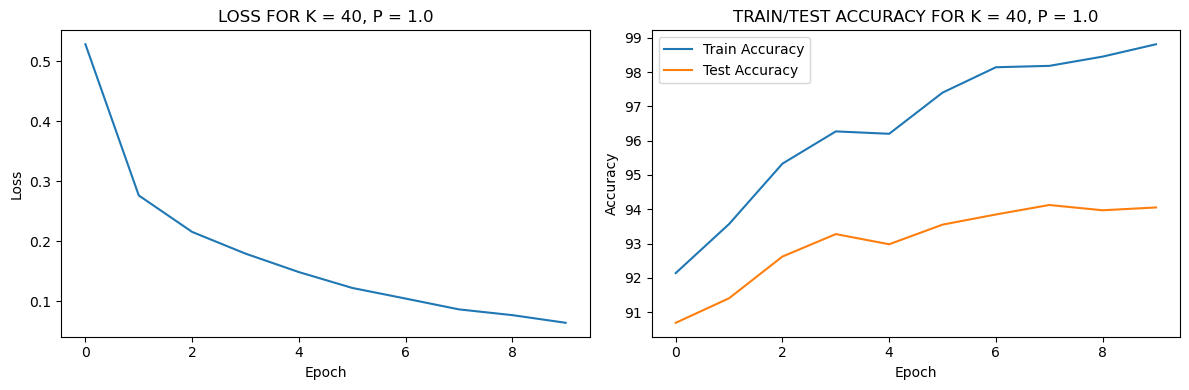


Loss for k=40, p=1.0: 0.064
Train Accuracy for k=40, p=1.0: 98.81%
Test Accuracy for k=40, p=1.0: 94.05%

Wall time: 1min 48s


In [8]:
%%time

k=40
p=1.0

t1_loss, t1_train_acc, t1_test_acc = general_shallow_net(train_loader, test_loader, 'ADAM', k, p, 10)

t1_mean_loss = t1_loss[-1]
t1_max_train_acc = t1_train_acc[-1]
t1_max_test_acc = t1_test_acc[-1]

print(f'Loss for k={k}, p={p}: {t1_mean_loss:.3f}')
print(f'Train Accuracy for k={k}, p={p}: {t1_max_train_acc:.2f}%')
print(f'Test Accuracy for k={k}, p={p}: {t1_max_test_acc:.2f}%')

print()

## *TASK 2 - (7 PTS)*

Pick the width grid K = [1, 5, 10, 20, 40] and dropout grid P = [0.1, 0.5, 1.0]. Run MNIST models over these grids with Adam optimizer for 80 epochs. Store the test/train accuracy and loss.

In [9]:
main_k = [1,5,10,20,40]
main_p = [0.1, 0.5, 1.0]

num_epochs = 80

task2_results = []

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=1, P=0.1 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 7.208, Train Accuracy: 10.00, Test Accuracy: 10.03
Epoch [20/80], Loss: 7.208, Train Accuracy: 10.00, Test Accuracy: 10.03
Epoch [30/80], Loss: 7.208, Train Accuracy: 10.00, Test Accuracy: 9.12
Epoch [40/80], Loss: 7.208, Train Accuracy: 10.00, Test Accuracy: 10.22
Epoch [50/80], Loss: 7.208, Train Accuracy: 10.00, Test Accuracy: 10.03
Epoch [60/80], Loss: 7.208, Train Accuracy: 10.00, Test Accuracy: 10.03
Epoch [70/80], Loss: 7.208, Train Accuracy: 10.00, Test Accuracy: 10.01
Epoch [80/80], Loss: 7.208, Train Accuracy: 10.00, Test Accuracy: 10.22

---------------------- FOR K: 1, P: 0.1 THE PLOTS ARE AS FOLLOWS ----------------------



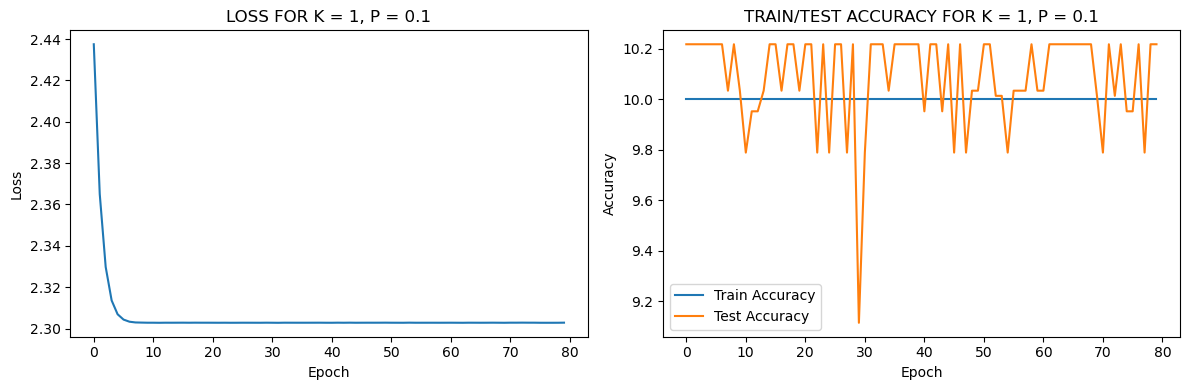


Loss for k=1, p=0.1: 2.303
Train Accuracy for k=1, p=0.1: 10.00%
Test Accuracy for k=1, p=0.1: 10.22%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=1, P=0.5 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 6.694, Train Accuracy: 15.81, Test Accuracy: 16.13
Epoch [20/80], Loss: 6.593, Train Accuracy: 16.76, Test Accuracy: 15.99
Epoch [30/80], Loss: 6.585, Train Accuracy: 16.90, Test Accuracy: 16.11
Epoch [40/80], Loss: 6.588, Train Accuracy: 16.72, Test Accuracy: 16.29
Epoch [50/80], Loss: 6.559, Train Accuracy: 17.04, Test Accuracy: 17.45
Epoch [60/80], Loss: 6.588, Train Accuracy: 16.47, Test Accuracy: 15.79
Epoch [70/80], Loss: 6.579, Train Accuracy: 17.02, Test Accuracy: 16.13
Epoch [80/80], Loss: 6.567, Train Accuracy: 17.04, Test Accuracy: 16.16

---------------------- FOR K: 1, P: 0.5 THE PLOTS ARE AS FOLLOWS ----------------------



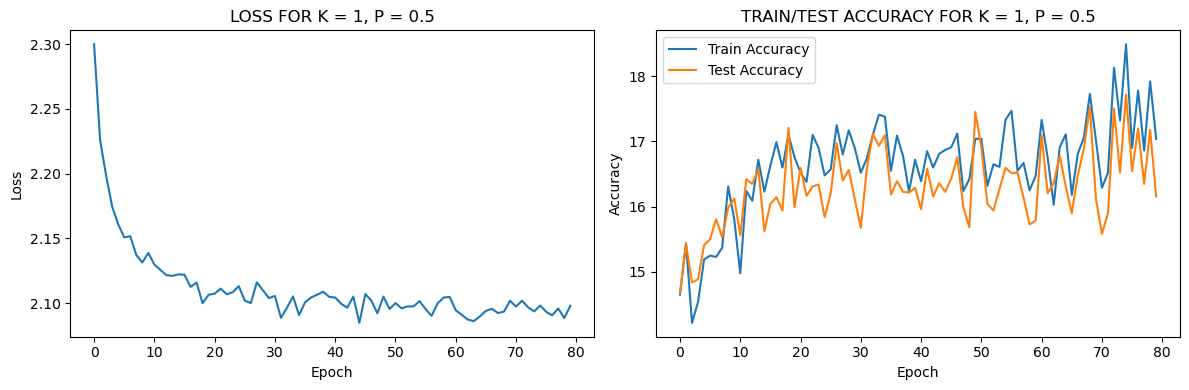


Loss for k=1, p=0.5: 2.098
Train Accuracy for k=1, p=0.5: 17.04%
Test Accuracy for k=1, p=0.5: 16.16%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=1, P=1.0 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 5.620, Train Accuracy: 24.46, Test Accuracy: 24.70
Epoch [20/80], Loss: 5.260, Train Accuracy: 29.06, Test Accuracy: 27.38
Epoch [30/80], Loss: 5.155, Train Accuracy: 31.84, Test Accuracy: 30.87
Epoch [40/80], Loss: 5.092, Train Accuracy: 30.12, Test Accuracy: 28.10
Epoch [50/80], Loss: 5.048, Train Accuracy: 34.24, Test Accuracy: 33.09
Epoch [60/80], Loss: 5.007, Train Accuracy: 32.79, Test Accuracy: 31.11
Epoch [70/80], Loss: 4.951, Train Accuracy: 39.29, Test Accuracy: 37.70
Epoch [80/80], Loss: 4.894, Train Accuracy: 39.43, Test Accuracy: 37.38

---------------------- FOR K: 1, P: 1.0 THE PLOTS ARE AS FOLLOWS ----------------------



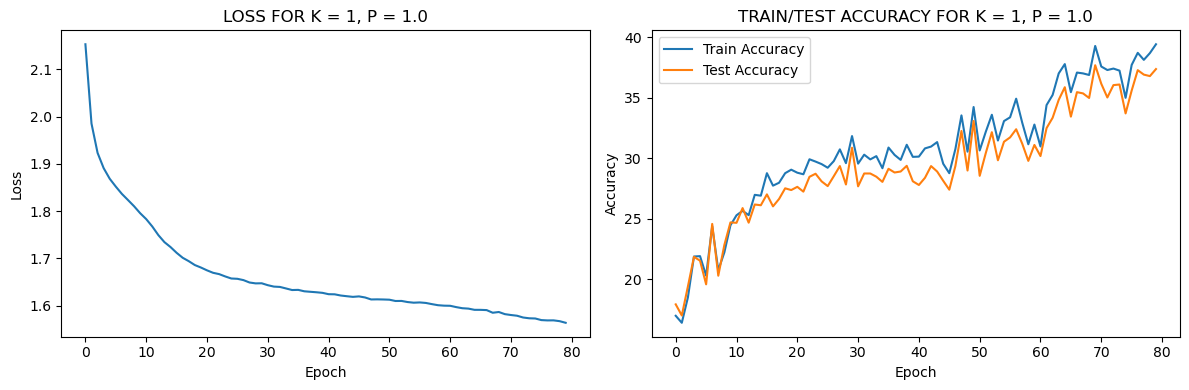


Loss for k=1, p=1.0: 1.563
Train Accuracy for k=1, p=1.0: 39.43%
Test Accuracy for k=1, p=1.0: 37.38%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=5, P=0.1 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 7.071, Train Accuracy: 12.30, Test Accuracy: 11.56
Epoch [20/80], Loss: 7.012, Train Accuracy: 12.53, Test Accuracy: 12.45
Epoch [30/80], Loss: 6.982, Train Accuracy: 12.83, Test Accuracy: 12.76
Epoch [40/80], Loss: 6.949, Train Accuracy: 12.74, Test Accuracy: 13.28
Epoch [50/80], Loss: 6.964, Train Accuracy: 12.89, Test Accuracy: 12.97
Epoch [60/80], Loss: 6.964, Train Accuracy: 12.72, Test Accuracy: 12.83
Epoch [70/80], Loss: 6.957, Train Accuracy: 13.32, Test Accuracy: 13.45
Epoch [80/80], Loss: 6.963, Train Accuracy: 12.83, Test Accuracy: 12.76

---------------------- FOR K: 5, P: 0.1 THE PLOTS ARE AS FOLLOWS ----------------------



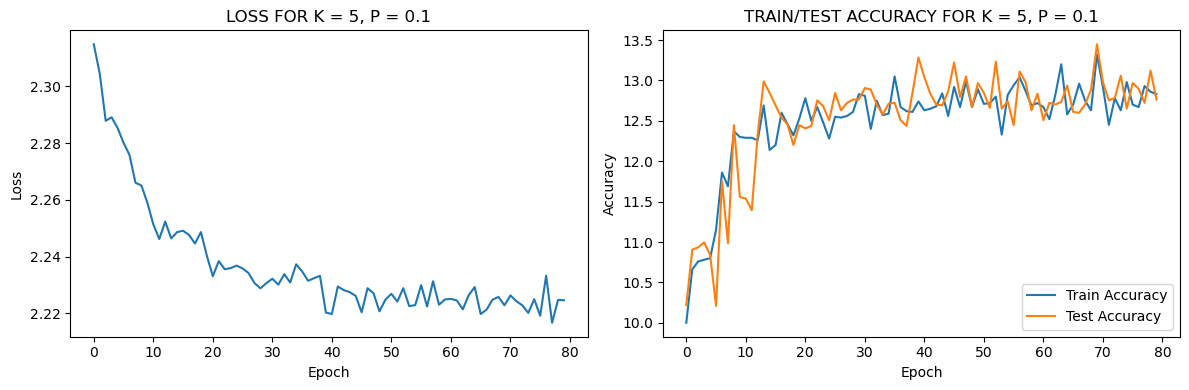


Loss for k=5, p=0.1: 2.225
Train Accuracy for k=5, p=0.1: 12.83%
Test Accuracy for k=5, p=0.1: 12.76%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=5, P=0.5 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 4.770, Train Accuracy: 40.67, Test Accuracy: 40.06
Epoch [20/80], Loss: 4.731, Train Accuracy: 40.88, Test Accuracy: 40.71
Epoch [30/80], Loss: 4.670, Train Accuracy: 39.75, Test Accuracy: 39.14
Epoch [40/80], Loss: 4.705, Train Accuracy: 40.26, Test Accuracy: 40.83
Epoch [50/80], Loss: 4.612, Train Accuracy: 41.74, Test Accuracy: 40.04
Epoch [60/80], Loss: 4.626, Train Accuracy: 40.72, Test Accuracy: 40.48
Epoch [70/80], Loss: 4.641, Train Accuracy: 39.73, Test Accuracy: 39.27
Epoch [80/80], Loss: 4.588, Train Accuracy: 40.71, Test Accuracy: 38.94

---------------------- FOR K: 5, P: 0.5 THE PLOTS ARE AS FOLLOWS ----------------------



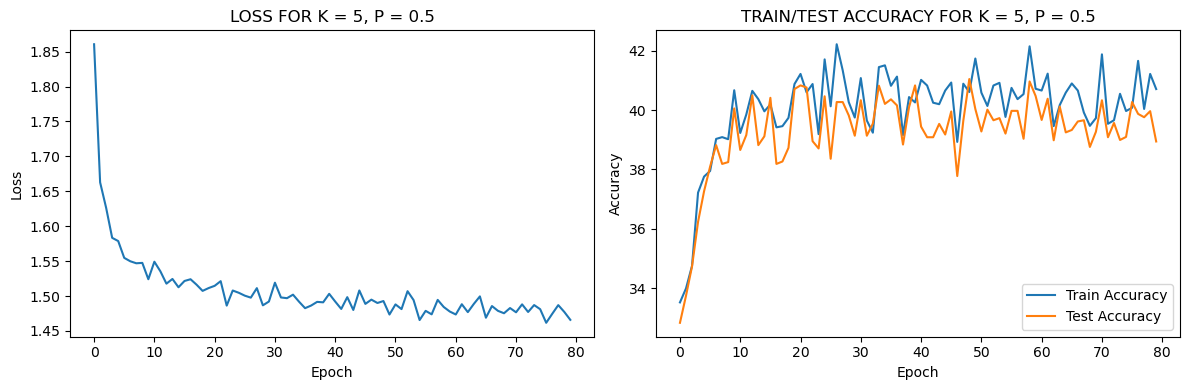


Loss for k=5, p=0.5: 1.466
Train Accuracy for k=5, p=0.5: 40.71%
Test Accuracy for k=5, p=0.5: 38.94%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=5, P=1.0 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 1.274, Train Accuracy: 89.80, Test Accuracy: 86.95
Epoch [20/80], Loss: 1.053, Train Accuracy: 91.10, Test Accuracy: 87.71
Epoch [30/80], Loss: 0.952, Train Accuracy: 91.92, Test Accuracy: 87.63
Epoch [40/80], Loss: 0.898, Train Accuracy: 92.80, Test Accuracy: 87.58
Epoch [50/80], Loss: 0.850, Train Accuracy: 92.77, Test Accuracy: 87.85
Epoch [60/80], Loss: 0.833, Train Accuracy: 93.27, Test Accuracy: 87.94
Epoch [70/80], Loss: 0.793, Train Accuracy: 93.14, Test Accuracy: 87.26
Epoch [80/80], Loss: 0.786, Train Accuracy: 93.64, Test Accuracy: 87.32

---------------------- FOR K: 5, P: 1.0 THE PLOTS ARE AS FOLLOWS ----------------------



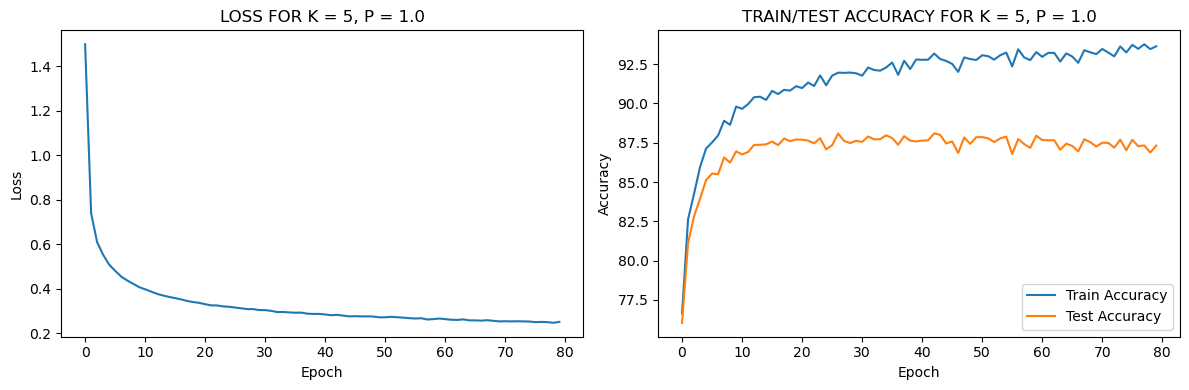


Loss for k=5, p=1.0: 0.251
Train Accuracy for k=5, p=1.0: 93.64%
Test Accuracy for k=5, p=1.0: 87.32%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=10, P=0.1 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 6.795, Train Accuracy: 15.45, Test Accuracy: 15.31
Epoch [20/80], Loss: 6.722, Train Accuracy: 15.52, Test Accuracy: 15.55
Epoch [30/80], Loss: 6.696, Train Accuracy: 16.44, Test Accuracy: 16.67
Epoch [40/80], Loss: 6.718, Train Accuracy: 15.94, Test Accuracy: 16.33
Epoch [50/80], Loss: 6.690, Train Accuracy: 15.17, Test Accuracy: 15.34
Epoch [60/80], Loss: 6.649, Train Accuracy: 15.10, Test Accuracy: 15.28
Epoch [70/80], Loss: 6.668, Train Accuracy: 15.44, Test Accuracy: 15.77
Epoch [80/80], Loss: 6.678, Train Accuracy: 15.52, Test Accuracy: 14.95

---------------------- FOR K: 10, P: 0.1 THE PLOTS ARE AS FOLLOWS ----------------------



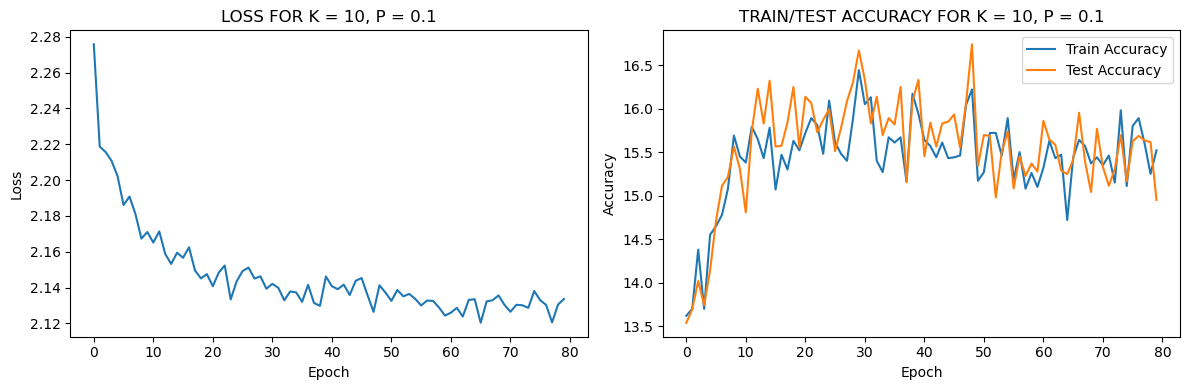


Loss for k=10, p=0.1: 2.134
Train Accuracy for k=10, p=0.1: 15.52%
Test Accuracy for k=10, p=0.1: 14.95%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=10, P=0.5 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 3.836, Train Accuracy: 53.33, Test Accuracy: 52.19
Epoch [20/80], Loss: 3.682, Train Accuracy: 55.36, Test Accuracy: 54.17
Epoch [30/80], Loss: 3.617, Train Accuracy: 56.29, Test Accuracy: 53.69
Epoch [40/80], Loss: 3.615, Train Accuracy: 56.95, Test Accuracy: 53.63
Epoch [50/80], Loss: 3.614, Train Accuracy: 57.16, Test Accuracy: 54.52
Epoch [60/80], Loss: 3.571, Train Accuracy: 57.10, Test Accuracy: 54.06
Epoch [70/80], Loss: 3.486, Train Accuracy: 56.59, Test Accuracy: 54.37
Epoch [80/80], Loss: 3.520, Train Accuracy: 57.06, Test Accuracy: 54.20

---------------------- FOR K: 10, P: 0.5 THE PLOTS ARE AS FOLLOWS ----------------------



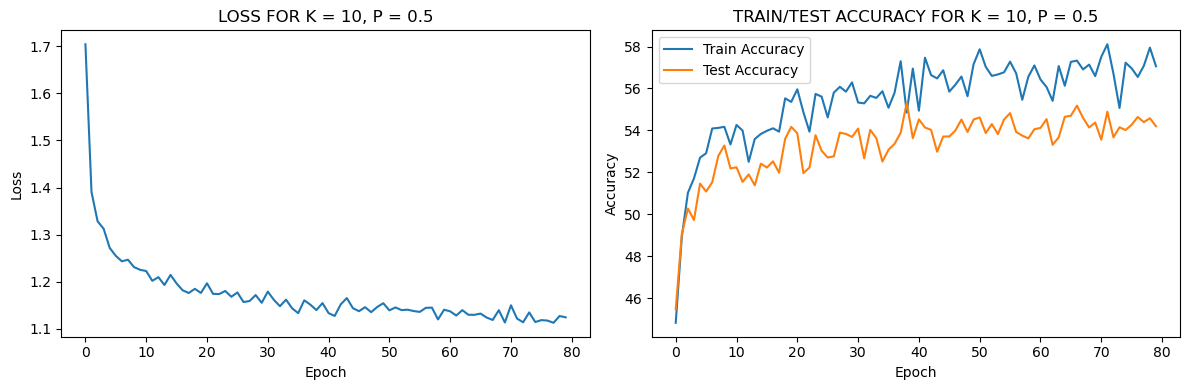


Loss for k=10, p=0.5: 1.125
Train Accuracy for k=10, p=0.5: 57.06%
Test Accuracy for k=10, p=0.5: 54.20%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=10, P=1.0 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 0.662, Train Accuracy: 94.73, Test Accuracy: 91.01
Epoch [20/80], Loss: 0.496, Train Accuracy: 96.11, Test Accuracy: 91.12
Epoch [30/80], Loss: 0.369, Train Accuracy: 97.16, Test Accuracy: 91.35
Epoch [40/80], Loss: 0.287, Train Accuracy: 97.87, Test Accuracy: 91.16
Epoch [50/80], Loss: 0.214, Train Accuracy: 98.31, Test Accuracy: 90.88
Epoch [60/80], Loss: 0.169, Train Accuracy: 98.79, Test Accuracy: 90.91
Epoch [70/80], Loss: 0.130, Train Accuracy: 99.38, Test Accuracy: 90.99
OBTAINED AN ACCURACY OF 99.52% AT EPOCH NO. 74 FOR K = 10 AND P = 0.0
OBTAINED AN ACCURACY OF 99.54% AT EPOCH NO. 77 FOR K = 10 AND P = 0.0
Epoch [80/80], Loss: 0.110, Train Accuracy: 99.57, Test Accuracy: 90.86
OBTAINED AN ACCURACY OF 99.57% AT EPO

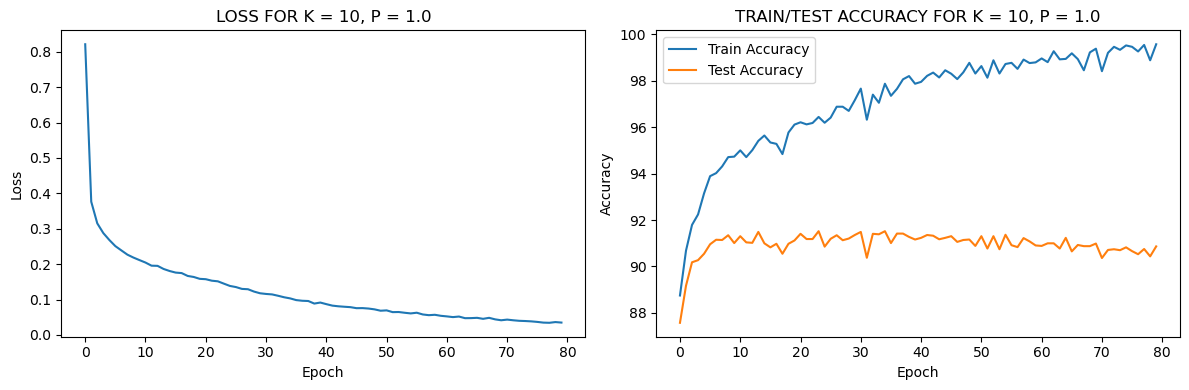


Loss for k=10, p=1.0: 0.035
Train Accuracy for k=10, p=1.0: 99.57%
Test Accuracy for k=10, p=1.0: 90.86%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=20, P=0.1 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 6.361, Train Accuracy: 18.62, Test Accuracy: 19.25
Epoch [20/80], Loss: 6.322, Train Accuracy: 18.93, Test Accuracy: 19.01
Epoch [30/80], Loss: 6.289, Train Accuracy: 18.89, Test Accuracy: 18.72
Epoch [40/80], Loss: 6.296, Train Accuracy: 19.38, Test Accuracy: 19.78
Epoch [50/80], Loss: 6.271, Train Accuracy: 19.04, Test Accuracy: 20.11
Epoch [60/80], Loss: 6.240, Train Accuracy: 19.45, Test Accuracy: 19.06
Epoch [70/80], Loss: 6.285, Train Accuracy: 19.45, Test Accuracy: 19.59
Epoch [80/80], Loss: 6.281, Train Accuracy: 19.99, Test Accuracy: 20.00

---------------------- FOR K: 20, P: 0.1 THE PLOTS ARE AS FOLLOWS ----------------------



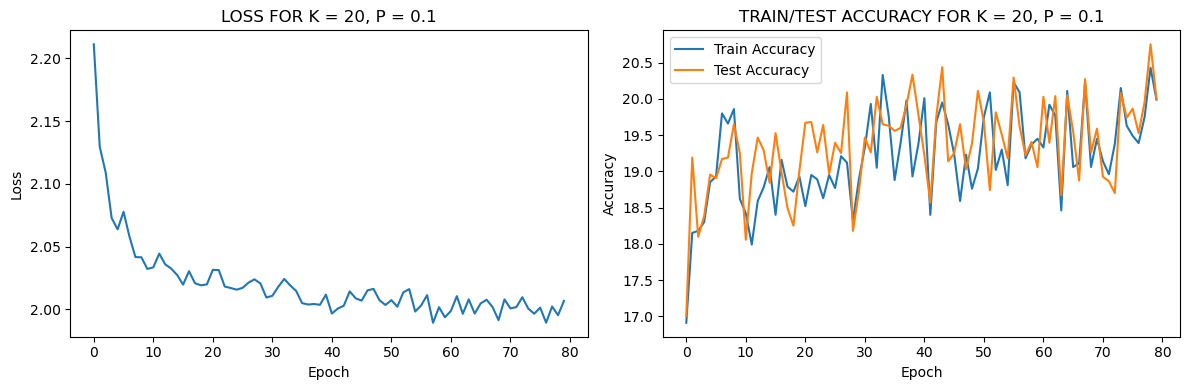


Loss for k=20, p=0.1: 2.007
Train Accuracy for k=20, p=0.1: 19.99%
Test Accuracy for k=20, p=0.1: 20.00%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=20, P=0.5 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 2.035, Train Accuracy: 77.94, Test Accuracy: 75.60
Epoch [20/80], Loss: 1.853, Train Accuracy: 79.65, Test Accuracy: 77.10
Epoch [30/80], Loss: 1.757, Train Accuracy: 79.70, Test Accuracy: 76.74
Epoch [40/80], Loss: 1.707, Train Accuracy: 79.33, Test Accuracy: 76.78
Epoch [50/80], Loss: 1.687, Train Accuracy: 79.94, Test Accuracy: 76.63
Epoch [60/80], Loss: 1.676, Train Accuracy: 80.65, Test Accuracy: 76.77
Epoch [70/80], Loss: 1.619, Train Accuracy: 81.30, Test Accuracy: 77.40
Epoch [80/80], Loss: 1.593, Train Accuracy: 81.06, Test Accuracy: 76.67

---------------------- FOR K: 20, P: 0.5 THE PLOTS ARE AS FOLLOWS ----------------------



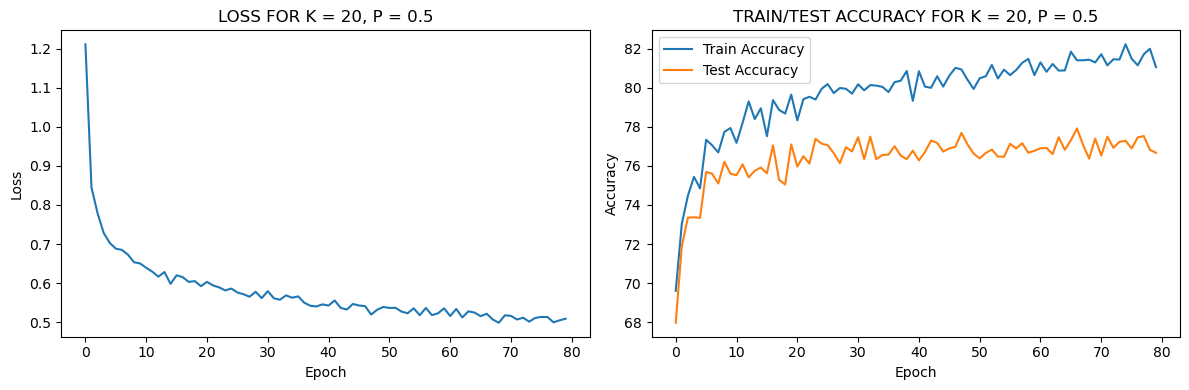


Loss for k=20, p=0.5: 0.509
Train Accuracy for k=20, p=0.5: 81.06%
Test Accuracy for k=20, p=0.5: 76.67%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=20, P=1.0 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 0.432, Train Accuracy: 96.90, Test Accuracy: 92.59
Epoch [20/80], Loss: 0.189, Train Accuracy: 98.91, Test Accuracy: 92.92
OBTAINED AN ACCURACY OF 99.58% AT EPOCH NO. 25 FOR K = 20 AND P = 0.0
OBTAINED AN ACCURACY OF 99.61% AT EPOCH NO. 27 FOR K = 20 AND P = 0.0
Epoch [30/80], Loss: 0.080, Train Accuracy: 99.22, Test Accuracy: 92.47
OBTAINED AN ACCURACY OF 99.79% AT EPOCH NO. 32 FOR K = 20 AND P = 0.0
OBTAINED AN ACCURACY OF 99.73% AT EPOCH NO. 33 FOR K = 20 AND P = 0.0
OBTAINED AN ACCURACY OF 99.64% AT EPOCH NO. 34 FOR K = 20 AND P = 0.0
OBTAINED AN ACCURACY OF 99.83% AT EPOCH NO. 35 FOR K = 20 AND P = 0.0
OBTAINED AN ACCURACY OF 99.9% AT EPOCH NO. 36 FOR K = 20 AND P = 0.0
OBTAINED AN ACCURACY OF 99.92% AT EPOCH NO. 37 F

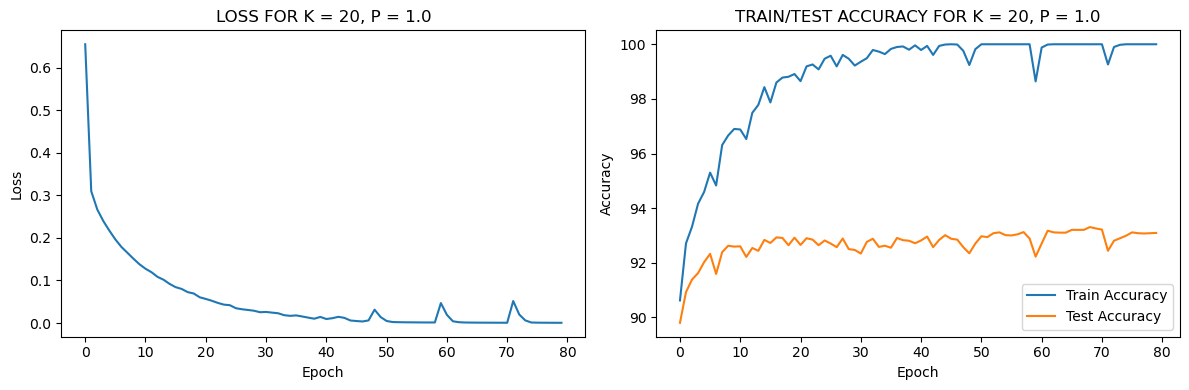


Loss for k=20, p=1.0: 0.001
Train Accuracy for k=20, p=1.0: 100.00%
Test Accuracy for k=20, p=1.0: 93.09%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=40, P=0.1 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 5.163, Train Accuracy: 34.45, Test Accuracy: 35.24
Epoch [20/80], Loss: 5.088, Train Accuracy: 36.50, Test Accuracy: 36.59
Epoch [30/80], Loss: 5.012, Train Accuracy: 37.03, Test Accuracy: 36.29
Epoch [40/80], Loss: 4.983, Train Accuracy: 37.42, Test Accuracy: 36.58
Epoch [50/80], Loss: 4.940, Train Accuracy: 37.74, Test Accuracy: 36.91
Epoch [60/80], Loss: 4.893, Train Accuracy: 37.55, Test Accuracy: 37.41
Epoch [70/80], Loss: 4.968, Train Accuracy: 38.63, Test Accuracy: 38.10
Epoch [80/80], Loss: 4.874, Train Accuracy: 39.41, Test Accuracy: 38.58

---------------------- FOR K: 40, P: 0.1 THE PLOTS ARE AS FOLLOWS ----------------------



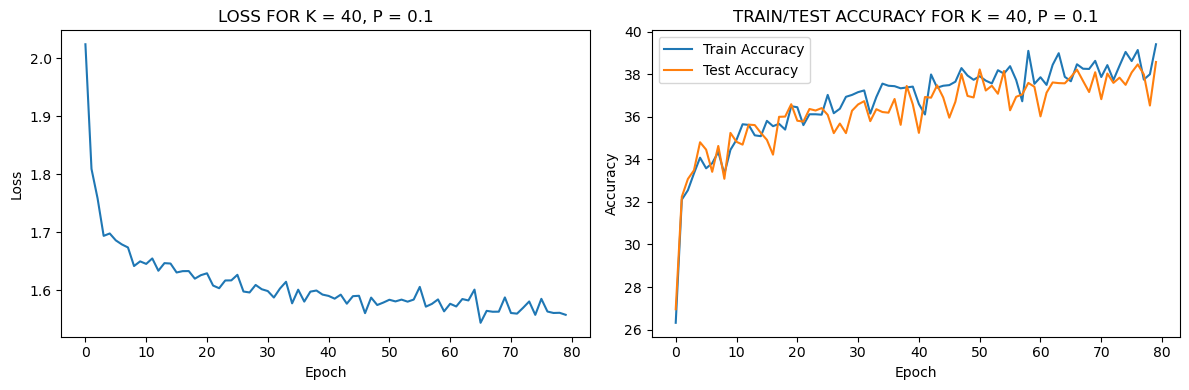


Loss for k=40, p=0.1: 1.557
Train Accuracy for k=40, p=0.1: 39.41%
Test Accuracy for k=40, p=0.1: 38.58%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=40, P=0.5 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 1.112, Train Accuracy: 88.75, Test Accuracy: 85.62
Epoch [20/80], Loss: 0.894, Train Accuracy: 90.77, Test Accuracy: 86.61
Epoch [30/80], Loss: 0.814, Train Accuracy: 91.46, Test Accuracy: 86.57
Epoch [40/80], Loss: 0.760, Train Accuracy: 91.35, Test Accuracy: 86.36
Epoch [50/80], Loss: 0.714, Train Accuracy: 92.18, Test Accuracy: 86.97
Epoch [60/80], Loss: 0.705, Train Accuracy: 92.14, Test Accuracy: 86.83
Epoch [70/80], Loss: 0.669, Train Accuracy: 92.54, Test Accuracy: 87.29
Epoch [80/80], Loss: 0.649, Train Accuracy: 92.46, Test Accuracy: 87.08

---------------------- FOR K: 40, P: 0.5 THE PLOTS ARE AS FOLLOWS ----------------------



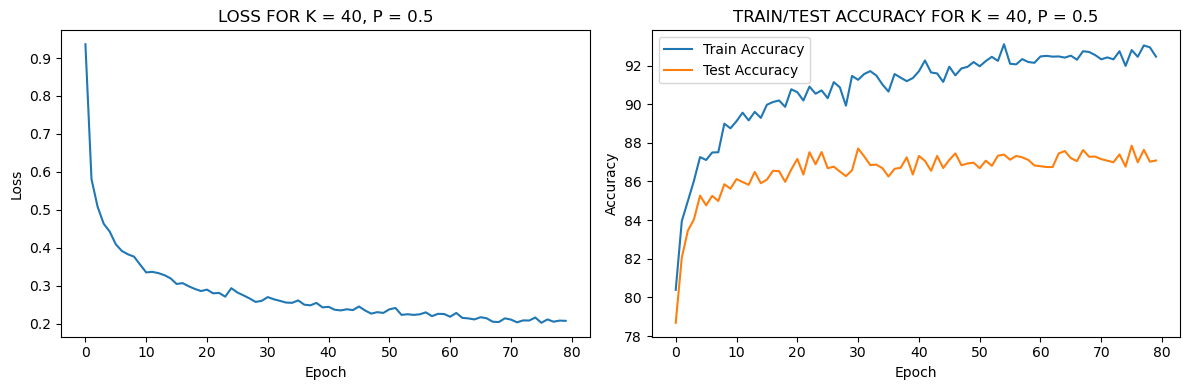


Loss for k=40, p=0.5: 0.207
Train Accuracy for k=40, p=0.5: 92.46%
Test Accuracy for k=40, p=0.5: 87.08%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=40, P=1.0 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 0.237, Train Accuracy: 98.64, Test Accuracy: 94.12
OBTAINED AN ACCURACY OF 99.62% AT EPOCH NO. 15 FOR K = 40 AND P = 0.0
OBTAINED AN ACCURACY OF 99.67% AT EPOCH NO. 16 FOR K = 40 AND P = 0.0
OBTAINED AN ACCURACY OF 99.69% AT EPOCH NO. 17 FOR K = 40 AND P = 0.0
OBTAINED AN ACCURACY OF 99.71% AT EPOCH NO. 18 FOR K = 40 AND P = 0.0
Epoch [20/80], Loss: 0.059, Train Accuracy: 99.81, Test Accuracy: 94.42
OBTAINED AN ACCURACY OF 99.81% AT EPOCH NO. 19 FOR K = 40 AND P = 0.0
OBTAINED AN ACCURACY OF 99.78% AT EPOCH NO. 20 FOR K = 40 AND P = 0.0
OBTAINED AN ACCURACY OF 99.56% AT EPOCH NO. 21 FOR K = 40 AND P = 0.0
OBTAINED AN ACCURACY OF 99.9% AT EPOCH NO. 22 FOR K = 40 AND P = 0.0
OBTAINED AN ACCURACY OF 99.96% AT EPOCH NO. 23 FOR

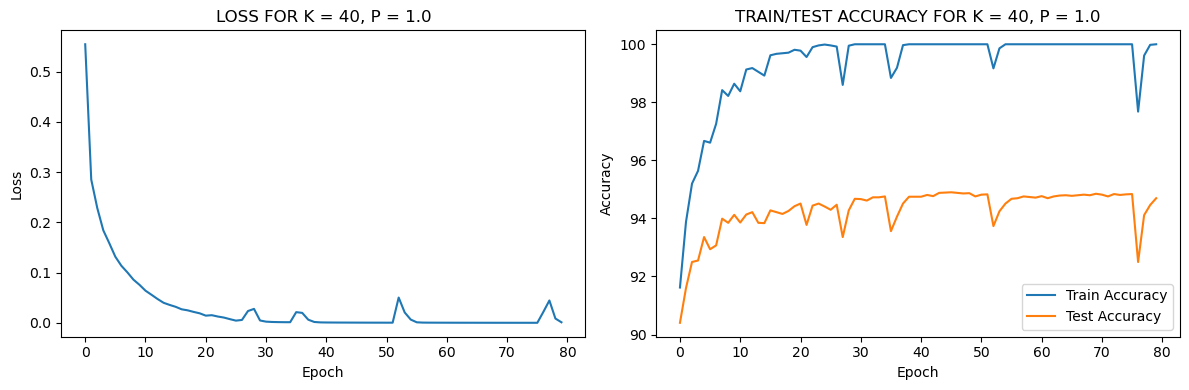


Loss for k=40, p=1.0: 0.001
Train Accuracy for k=40, p=1.0: 100.00%
Test Accuracy for k=40, p=1.0: 94.70%

Wall time: 3h 34min 35s


In [10]:
%%time

for k in main_k:
  for p in main_p:
    t21_loss, t21_train_acc, t21_test_acc = general_shallow_net(train_loader, test_loader, 'ADAM', k, p, num_epochs)
    
    t21_mean_loss = t21_loss[-1]
    t21_max_train_acc = t21_train_acc[-1]
    t21_max_test_acc = t21_test_acc[-1]
    
    print(f'Loss for k={k}, p={p}: {t21_mean_loss:.3f}')
    print(f'Train Accuracy for k={k}, p={p}: {t21_max_train_acc:.2f}%')
    print(f'Test Accuracy for k={k}, p={p}: {t21_max_test_acc:.2f}%')
    
    t2_total_summary = {'Hidden Units': k, 'Dropout Factor': p, 'Mean Loss': t21_mean_loss, 'Train Accuracy': t21_max_train_acc, 'Test Accuracy': t21_max_test_acc}
    task2_results.append(t2_total_summary)

    print()

### Fix p = 1.0 which is the case of “no dropout regularization”. Plot the test and training accuracy as a function of k. As k increases, does the performance improve? At what k, training accuracy becomes 100% ?

In [11]:
task2_results_df = pd.DataFrame(task2_results)
task2_results_df

,Hidden Units,Dropout Factor,Mean Loss,Train Accuracy,Test Accuracy
0,1,0.1,2.302839,10.00,10.218680
1,1,0.5,2.097958,17.04,16.155733
2,1,1.0,1.563459,39.43,37.379931
3,5,0.1,2.224583,12.83,12.763131
4,5,0.5,1.465939,40.71,38.943389
5,5,1.0,0.251154,93.64,87.318618
6,10,0.1,2.133704,15.52,14.949928
7,10,0.5,1.124713,57.06,54.199877
8,10,1.0,0.035008,99.57,90.864500
9,20,0.1,2.006705,19.99,19.997956


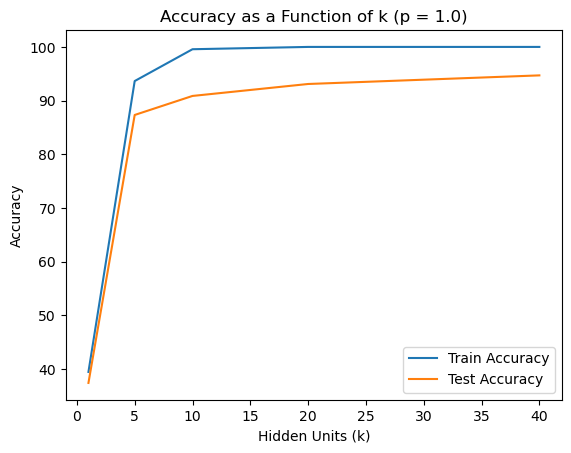

In [12]:
# Filter the DataFrame for rows where p = 1.0
filtered_df = task2_results_df[task2_results_df['Dropout Factor'] == 1.0]

# Plot the test and training accuracy
plt.plot(filtered_df['Hidden Units'], filtered_df['Train Accuracy'], label='Train Accuracy')
plt.plot(filtered_df['Hidden Units'], filtered_df['Test Accuracy'], label='Test Accuracy')
plt.title('Accuracy as a Function of k (p = 1.0)')
plt.xlabel('Hidden Units (k)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As the K increases, the model's performance also increases, as the model becomes more complex and gets the tendency to generalize itself better on the unseen data. 

At K = 20, the training Accuracy Becomes 100%

### Plot the training and test accuracy as a function of k and for different p ∈ P on the  same plot. What is the role of p on training accuracy? When p is smaller, is it easier to optimize or more difficult? For each choice of p, determine at what choice of k, training accuracy becomes 100%.

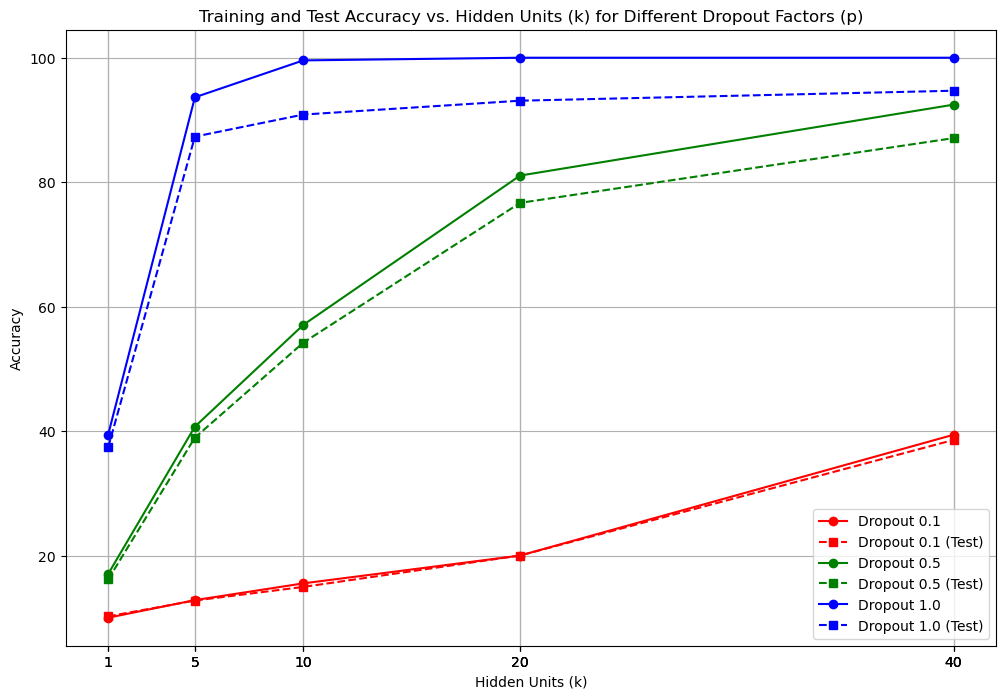

In [25]:
# Group the DataFrame by Dropout Factor
grouped_df = task2_results_df.groupby('Dropout Factor')

# Set the colors for the plot
colors = ['r', 'g', 'b']

# Plot the training and test accuracy for different Dropout Factors
plt.figure(figsize=(12, 8))

for i, (dropout, group) in enumerate(grouped_df):
    plt.plot(group['Hidden Units'], group['Train Accuracy'], marker='o', color=colors[i], label=f'Dropout {dropout}')
    plt.plot(group['Hidden Units'], group['Test Accuracy'], marker='s', color=colors[i], linestyle='--', label=f'Dropout {dropout} (Test)')

plt.title('Training and Test Accuracy vs. Hidden Units (k) for Different Dropout Factors (p)')
plt.xlabel('Hidden Units (k)')
plt.ylabel('Accuracy')
plt.xticks(task2_results_df['Hidden Units'])
plt.legend()
plt.grid(True)
plt.show()

As P (Dropout Factor) increases, the Training Accuracy of the Model for a given and fixed depth also improves. When P is smaller, it is difficult to Optimize. 

For P = 0.1 and 0.5, no values of K showed Training Accuracy of 100%. But for P = 1.0, K = 10 showed 99.57% Training Accuracy but K = 20 and 40 gave 100%.

## *TASK 3 - (7 PTS)*

We will spice up the problem by adding some noise to labels. Pick 40% of the training examples
at random. Assign their labels at random to another value from 0 to 9. For instance, if the original
image is 0 and its label is 0, then you will assign its label to a number from 1 to 9 at random. Thus
60% of the training examples remain correct and 40% will have incorrect labels. Repeat the previous
step with this noisy dataset.

### *PREPARING THE NOISY DATA*

In [15]:
# Copy the original training data
noisy_train_data = list(train_data)
noisy_train_labels = [label for _, label in noisy_train_data]

# Pick 40% of the training examples
num_examples = len(noisy_train_data)
num_noisy_examples = int(0.4 * num_examples)
noisy_indices = random.sample(range(num_examples), num_noisy_examples)

# Assign random incorrect labels to the noisy examples
for index in noisy_indices:
    original_label = noisy_train_labels[index]
    new_label = random.choice([label for label in range(10) if label != original_label])
    noisy_train_labels[index] = new_label

# Update the labels in the noisy training data
noisy_train_data = [(image, label) for (image, _), label in zip(noisy_train_data, noisy_train_labels)]

In [16]:
noisy_train_loader = DataLoader(noisy_train_data, batch_size=100, shuffle=True)

### *MAIN CODE*

In [17]:
k_for_noisy = [1,5,10,20,40]
p_for_noisy = [0.1, 0.5, 1.0]

num_epochs = 80

task3_results = []

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=1, P=0.1 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 2.307, Train Accuracy: 9.94, Test Accuracy: 10.22
Epoch [20/80], Loss: 2.303, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [30/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [40/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [50/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [60/80], Loss: 2.303, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [70/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [80/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79

---------------------- FOR K: 1, P: 0.1 THE PLOTS ARE AS FOLLOWS ----------------------



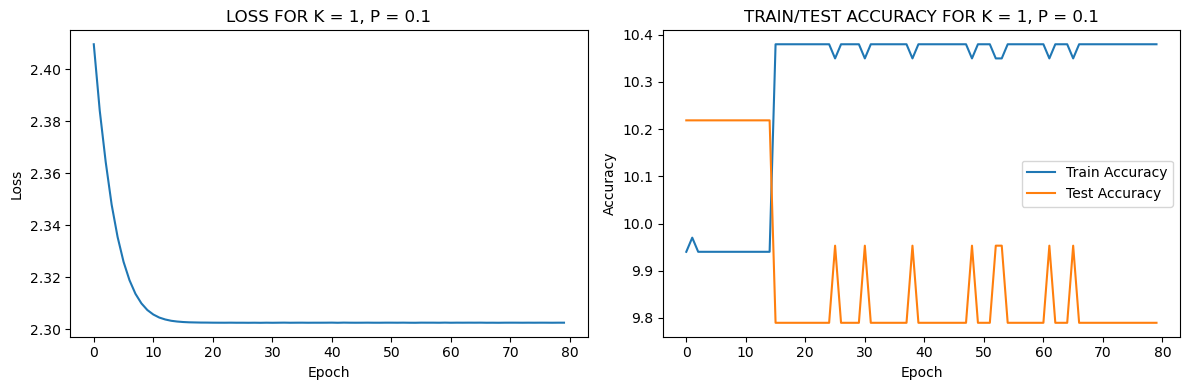


Mean Loss for k=1, p=0.1: 2.302
Max Train Accuracy for k=1, p=0.1: 10.38%
Max Test Accuracy for k=1, p=0.1: 9.79%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=1, P=0.5 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 2.275, Train Accuracy: 13.86, Test Accuracy: 15.00
Epoch [20/80], Loss: 2.260, Train Accuracy: 12.82, Test Accuracy: 14.50
Epoch [30/80], Loss: 2.259, Train Accuracy: 13.07, Test Accuracy: 14.47
Epoch [40/80], Loss: 2.250, Train Accuracy: 12.65, Test Accuracy: 14.31
Epoch [50/80], Loss: 2.256, Train Accuracy: 12.98, Test Accuracy: 14.38
Epoch [60/80], Loss: 2.253, Train Accuracy: 13.09, Test Accuracy: 14.35
Epoch [70/80], Loss: 2.251, Train Accuracy: 12.69, Test Accuracy: 13.83
Epoch [80/80], Loss: 2.254, Train Accuracy: 12.60, Test Accuracy: 13.65

---------------------- FOR K: 1, P: 0.5 THE PLOTS ARE AS FOLLOWS ----------------------



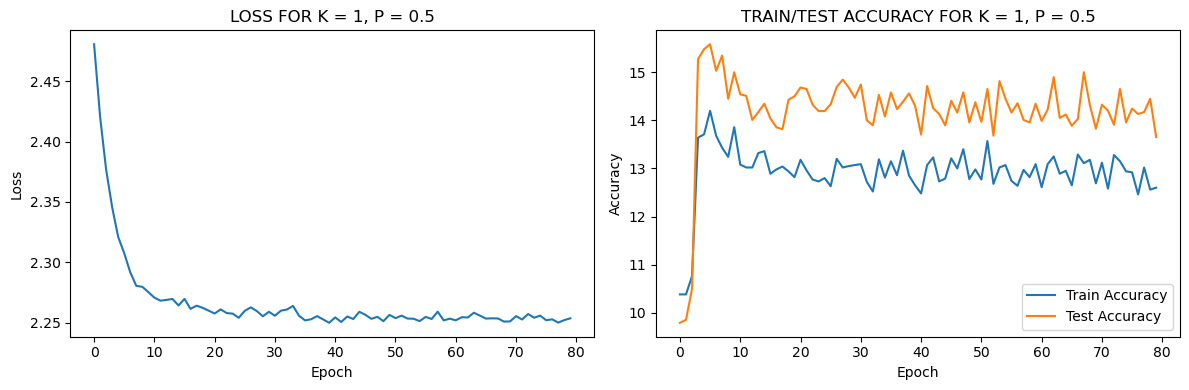


Mean Loss for k=1, p=0.5: 2.254
Max Train Accuracy for k=1, p=0.5: 12.60%
Max Test Accuracy for k=1, p=0.5: 13.65%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=1, P=1.0 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 2.312, Train Accuracy: 9.90, Test Accuracy: 10.22
Epoch [20/80], Loss: 2.303, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [30/80], Loss: 2.303, Train Accuracy: 10.35, Test Accuracy: 9.95
Epoch [40/80], Loss: 2.303, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [50/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [60/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [70/80], Loss: 2.303, Train Accuracy: 10.35, Test Accuracy: 9.95
Epoch [80/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79

---------------------- FOR K: 1, P: 1.0 THE PLOTS ARE AS FOLLOWS ----------------------



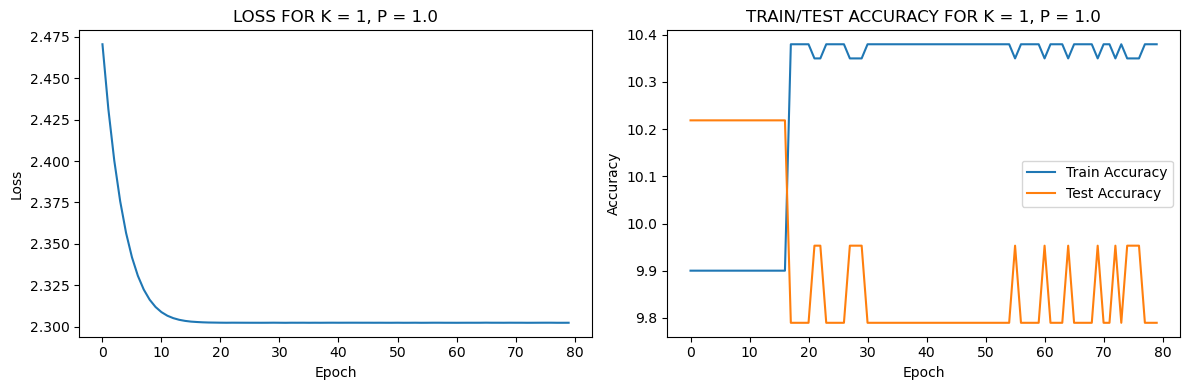


Mean Loss for k=1, p=1.0: 2.302
Max Train Accuracy for k=1, p=1.0: 10.38%
Max Test Accuracy for k=1, p=1.0: 9.79%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=5, P=0.1 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 2.303, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [20/80], Loss: 2.303, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [30/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [40/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [50/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [60/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [70/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [80/80], Loss: 2.303, Train Accuracy: 10.38, Test Accuracy: 9.79

---------------------- FOR K: 5, P: 0.1 THE PLOTS ARE AS FOLLOWS ----------------------



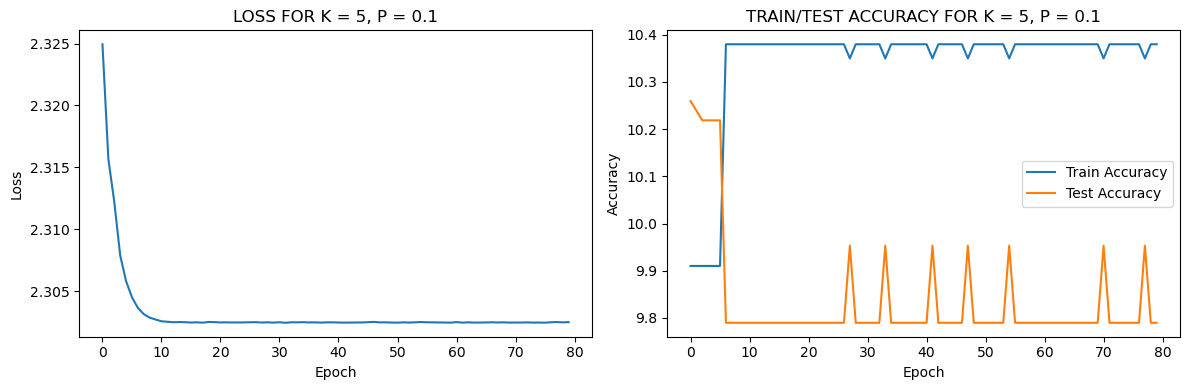


Mean Loss for k=5, p=0.1: 2.303
Max Train Accuracy for k=5, p=0.1: 10.38%
Max Test Accuracy for k=5, p=0.1: 9.79%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=5, P=0.5 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 2.181, Train Accuracy: 18.80, Test Accuracy: 25.63
Epoch [20/80], Loss: 2.169, Train Accuracy: 19.61, Test Accuracy: 27.19
Epoch [30/80], Loss: 2.163, Train Accuracy: 20.22, Test Accuracy: 27.55
Epoch [40/80], Loss: 2.161, Train Accuracy: 19.81, Test Accuracy: 27.07
Epoch [50/80], Loss: 2.163, Train Accuracy: 20.60, Test Accuracy: 27.75
Epoch [60/80], Loss: 2.162, Train Accuracy: 20.72, Test Accuracy: 27.90
Epoch [70/80], Loss: 2.154, Train Accuracy: 20.39, Test Accuracy: 26.75
Epoch [80/80], Loss: 2.164, Train Accuracy: 20.33, Test Accuracy: 27.09

---------------------- FOR K: 5, P: 0.5 THE PLOTS ARE AS FOLLOWS ----------------------



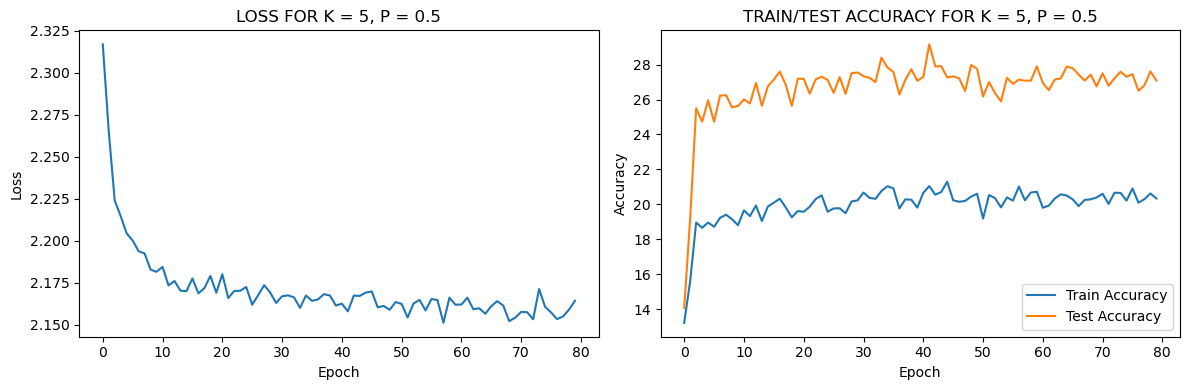


Mean Loss for k=5, p=0.5: 2.164
Max Train Accuracy for k=5, p=0.5: 20.33%
Max Test Accuracy for k=5, p=0.5: 27.09%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=5, P=1.0 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 1.817, Train Accuracy: 50.78, Test Accuracy: 78.69
Epoch [20/80], Loss: 1.777, Train Accuracy: 51.47, Test Accuracy: 78.91
Epoch [30/80], Loss: 1.753, Train Accuracy: 52.02, Test Accuracy: 78.87
Epoch [40/80], Loss: 1.733, Train Accuracy: 52.50, Test Accuracy: 79.42
Epoch [50/80], Loss: 1.728, Train Accuracy: 51.94, Test Accuracy: 78.02
Epoch [60/80], Loss: 1.715, Train Accuracy: 52.46, Test Accuracy: 78.34
Epoch [70/80], Loss: 1.709, Train Accuracy: 52.29, Test Accuracy: 77.08
Epoch [80/80], Loss: 1.705, Train Accuracy: 52.57, Test Accuracy: 76.84

---------------------- FOR K: 5, P: 1.0 THE PLOTS ARE AS FOLLOWS ----------------------



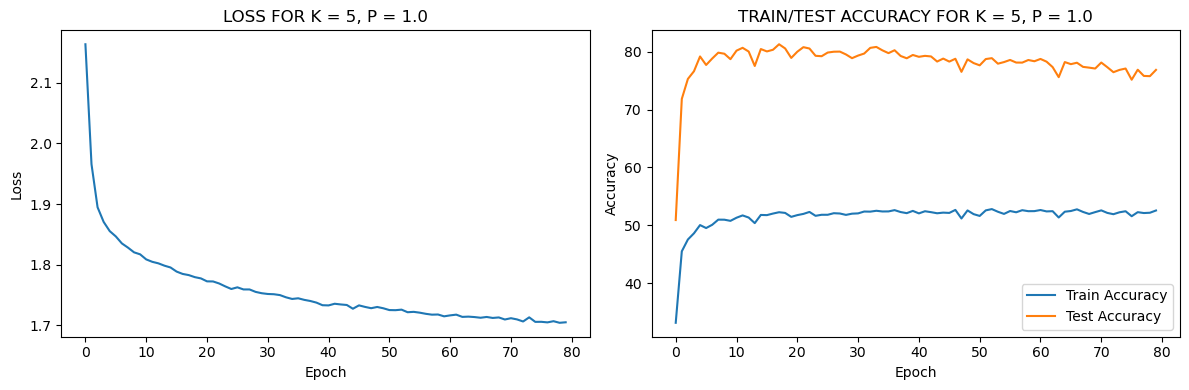


Mean Loss for k=5, p=1.0: 1.705
Max Train Accuracy for k=5, p=1.0: 52.57%
Max Test Accuracy for k=5, p=1.0: 76.84%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=10, P=0.1 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 2.302, Train Accuracy: 10.35, Test Accuracy: 9.96
Epoch [20/80], Loss: 2.302, Train Accuracy: 10.35, Test Accuracy: 9.96
Epoch [30/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [40/80], Loss: 2.302, Train Accuracy: 10.39, Test Accuracy: 9.79
Epoch [50/80], Loss: 2.303, Train Accuracy: 10.35, Test Accuracy: 9.95
Epoch [60/80], Loss: 2.302, Train Accuracy: 10.35, Test Accuracy: 9.95
Epoch [70/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79
Epoch [80/80], Loss: 2.302, Train Accuracy: 10.38, Test Accuracy: 9.79

---------------------- FOR K: 10, P: 0.1 THE PLOTS ARE AS FOLLOWS ----------------------



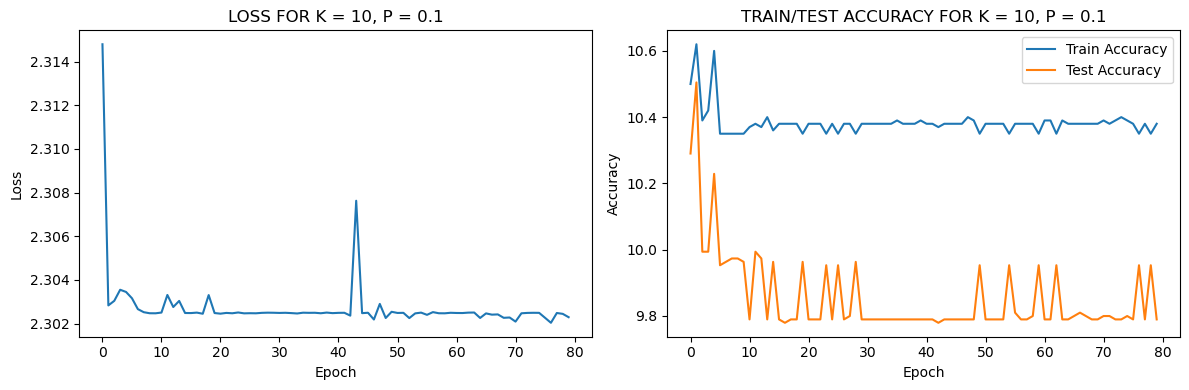


Mean Loss for k=10, p=0.1: 2.302
Max Train Accuracy for k=10, p=0.1: 10.38%
Max Test Accuracy for k=10, p=0.1: 9.79%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=10, P=0.5 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 1.996, Train Accuracy: 32.37, Test Accuracy: 47.57
Epoch [20/80], Loss: 1.971, Train Accuracy: 33.55, Test Accuracy: 50.02
Epoch [30/80], Loss: 1.970, Train Accuracy: 34.06, Test Accuracy: 49.09
Epoch [40/80], Loss: 1.964, Train Accuracy: 33.97, Test Accuracy: 49.81
Epoch [50/80], Loss: 1.956, Train Accuracy: 34.46, Test Accuracy: 49.03
Epoch [60/80], Loss: 1.964, Train Accuracy: 34.10, Test Accuracy: 49.36
Epoch [70/80], Loss: 1.947, Train Accuracy: 35.41, Test Accuracy: 49.66
Epoch [80/80], Loss: 1.931, Train Accuracy: 34.80, Test Accuracy: 49.41

---------------------- FOR K: 10, P: 0.5 THE PLOTS ARE AS FOLLOWS ----------------------



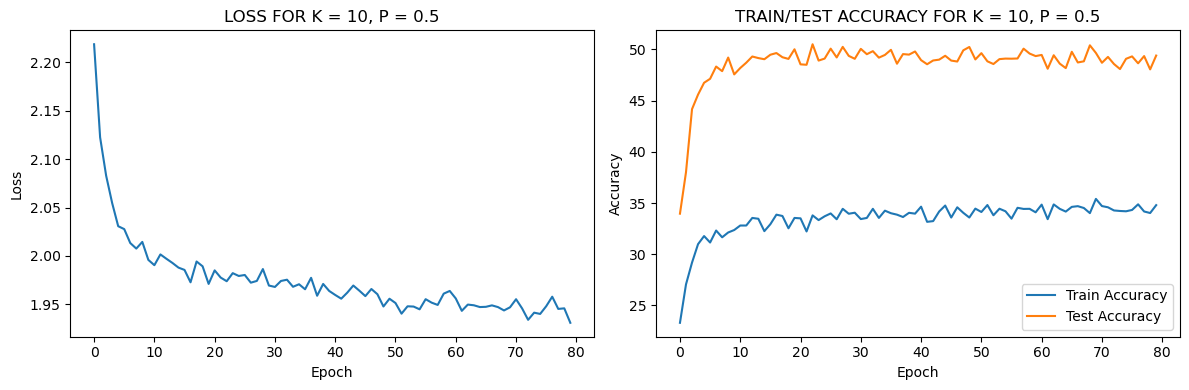


Mean Loss for k=10, p=0.5: 1.931
Max Train Accuracy for k=10, p=0.5: 34.80%
Max Test Accuracy for k=10, p=0.5: 49.41%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=10, P=1.0 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 1.687, Train Accuracy: 53.95, Test Accuracy: 86.16
Epoch [20/80], Loss: 1.639, Train Accuracy: 54.69, Test Accuracy: 84.92
Epoch [30/80], Loss: 1.608, Train Accuracy: 54.78, Test Accuracy: 83.11
Epoch [40/80], Loss: 1.588, Train Accuracy: 55.03, Test Accuracy: 82.90
Epoch [50/80], Loss: 1.570, Train Accuracy: 55.14, Test Accuracy: 81.39
Epoch [60/80], Loss: 1.554, Train Accuracy: 55.06, Test Accuracy: 80.52
Epoch [70/80], Loss: 1.542, Train Accuracy: 55.66, Test Accuracy: 80.50
Epoch [80/80], Loss: 1.531, Train Accuracy: 55.80, Test Accuracy: 77.90

---------------------- FOR K: 10, P: 1.0 THE PLOTS ARE AS FOLLOWS ----------------------



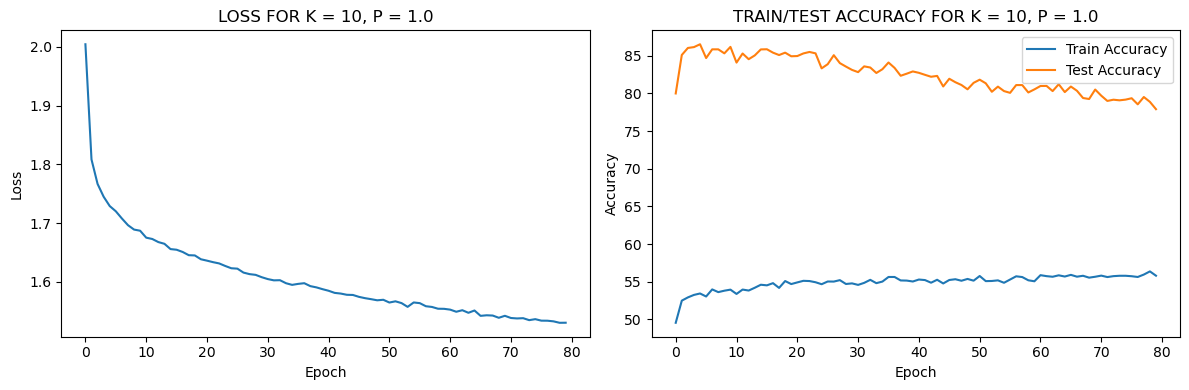


Mean Loss for k=10, p=1.0: 1.531
Max Train Accuracy for k=10, p=1.0: 55.80%
Max Test Accuracy for k=10, p=1.0: 77.90%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=20, P=0.1 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 2.287, Train Accuracy: 12.09, Test Accuracy: 13.11
Epoch [20/80], Loss: 2.277, Train Accuracy: 12.29, Test Accuracy: 13.23
Epoch [30/80], Loss: 2.272, Train Accuracy: 12.26, Test Accuracy: 13.29
Epoch [40/80], Loss: 2.268, Train Accuracy: 11.94, Test Accuracy: 13.30
Epoch [50/80], Loss: 2.266, Train Accuracy: 12.17, Test Accuracy: 13.47
Epoch [60/80], Loss: 2.271, Train Accuracy: 12.50, Test Accuracy: 13.53
Epoch [70/80], Loss: 2.264, Train Accuracy: 12.46, Test Accuracy: 14.14
Epoch [80/80], Loss: 2.265, Train Accuracy: 12.60, Test Accuracy: 14.29

---------------------- FOR K: 20, P: 0.1 THE PLOTS ARE AS FOLLOWS ----------------------



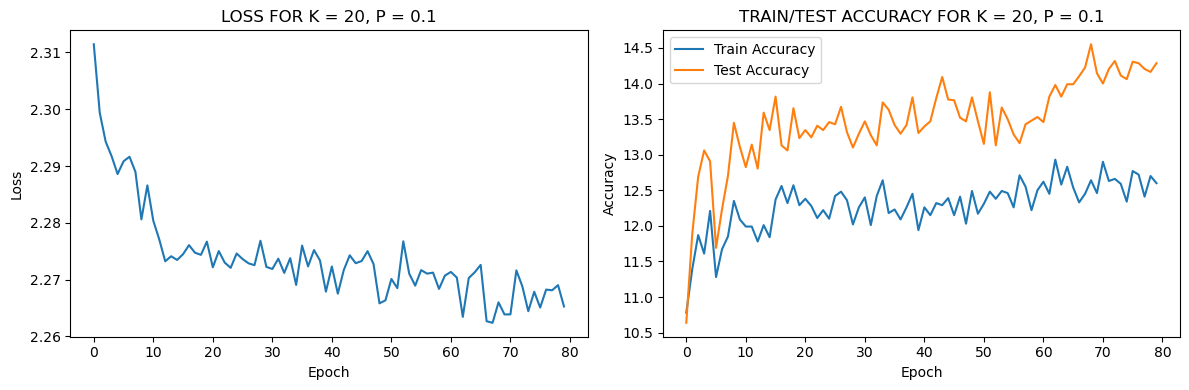


Mean Loss for k=20, p=0.1: 2.265
Max Train Accuracy for k=20, p=0.1: 12.60%
Max Test Accuracy for k=20, p=0.1: 14.29%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=20, P=0.5 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 1.901, Train Accuracy: 41.84, Test Accuracy: 64.95
Epoch [20/80], Loss: 1.870, Train Accuracy: 43.00, Test Accuracy: 66.27
Epoch [30/80], Loss: 1.845, Train Accuracy: 43.65, Test Accuracy: 64.28
Epoch [40/80], Loss: 1.838, Train Accuracy: 42.98, Test Accuracy: 64.08
Epoch [50/80], Loss: 1.823, Train Accuracy: 43.88, Test Accuracy: 64.05
Epoch [60/80], Loss: 1.821, Train Accuracy: 43.38, Test Accuracy: 63.25
Epoch [70/80], Loss: 1.807, Train Accuracy: 43.56, Test Accuracy: 63.25
Epoch [80/80], Loss: 1.801, Train Accuracy: 43.80, Test Accuracy: 62.61

---------------------- FOR K: 20, P: 0.5 THE PLOTS ARE AS FOLLOWS ----------------------



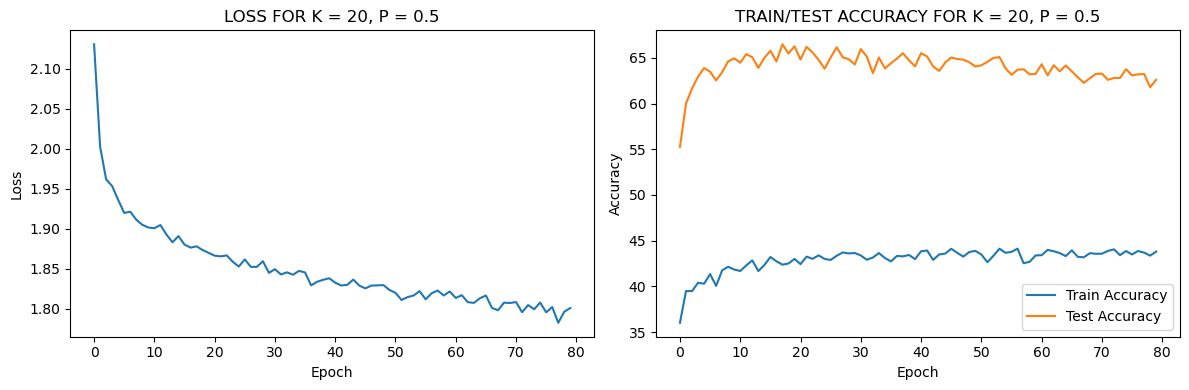


Mean Loss for k=20, p=0.5: 1.801
Max Train Accuracy for k=20, p=0.5: 43.80%
Max Test Accuracy for k=20, p=0.5: 62.61%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=20, P=1.0 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 1.622, Train Accuracy: 55.10, Test Accuracy: 87.54
Epoch [20/80], Loss: 1.537, Train Accuracy: 56.85, Test Accuracy: 85.95
Epoch [30/80], Loss: 1.481, Train Accuracy: 57.66, Test Accuracy: 84.67
Epoch [40/80], Loss: 1.438, Train Accuracy: 58.32, Test Accuracy: 82.46
Epoch [50/80], Loss: 1.404, Train Accuracy: 59.11, Test Accuracy: 81.56
Epoch [60/80], Loss: 1.372, Train Accuracy: 59.60, Test Accuracy: 79.06
Epoch [70/80], Loss: 1.351, Train Accuracy: 59.81, Test Accuracy: 77.30
Epoch [80/80], Loss: 1.323, Train Accuracy: 61.03, Test Accuracy: 76.34

---------------------- FOR K: 20, P: 1.0 THE PLOTS ARE AS FOLLOWS ----------------------



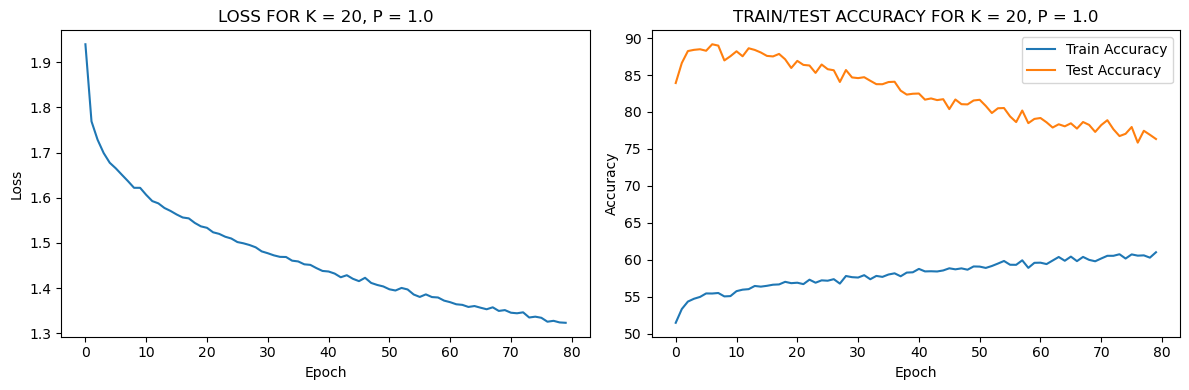


Mean Loss for k=20, p=1.0: 1.323
Max Train Accuracy for k=20, p=1.0: 61.03%
Max Test Accuracy for k=20, p=1.0: 76.34%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=40, P=0.1 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 2.242, Train Accuracy: 15.05, Test Accuracy: 18.92
Epoch [20/80], Loss: 2.223, Train Accuracy: 15.94, Test Accuracy: 20.28
Epoch [30/80], Loss: 2.218, Train Accuracy: 15.97, Test Accuracy: 19.70
Epoch [40/80], Loss: 2.229, Train Accuracy: 16.40, Test Accuracy: 20.08
Epoch [50/80], Loss: 2.225, Train Accuracy: 15.98, Test Accuracy: 19.92
Epoch [60/80], Loss: 2.225, Train Accuracy: 15.89, Test Accuracy: 20.07
Epoch [70/80], Loss: 2.219, Train Accuracy: 16.29, Test Accuracy: 20.17
Epoch [80/80], Loss: 2.217, Train Accuracy: 15.77, Test Accuracy: 19.55

---------------------- FOR K: 40, P: 0.1 THE PLOTS ARE AS FOLLOWS ----------------------



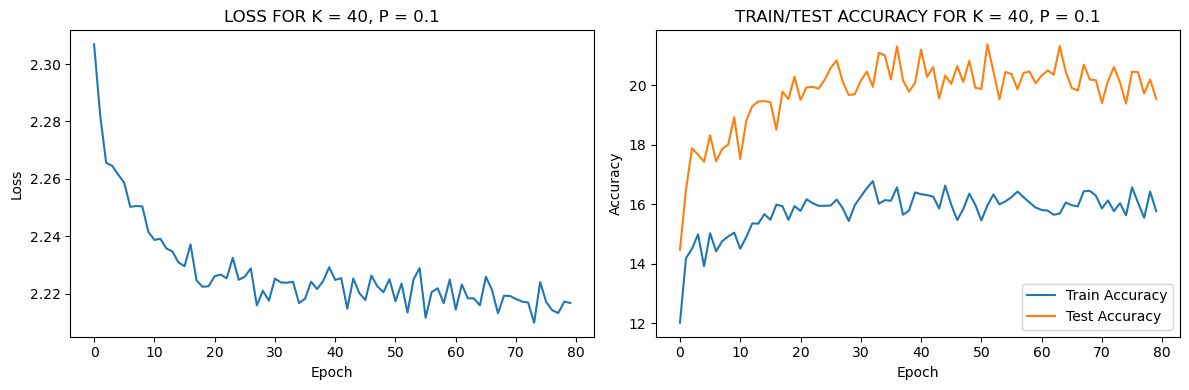


Mean Loss for k=40, p=0.1: 2.217
Max Train Accuracy for k=40, p=0.1: 15.77%
Max Test Accuracy for k=40, p=0.1: 19.55%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=40, P=0.5 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 1.799, Train Accuracy: 48.79, Test Accuracy: 75.82
Epoch [20/80], Loss: 1.756, Train Accuracy: 48.86, Test Accuracy: 74.90
Epoch [30/80], Loss: 1.735, Train Accuracy: 49.67, Test Accuracy: 75.78
Epoch [40/80], Loss: 1.702, Train Accuracy: 49.97, Test Accuracy: 72.64
Epoch [50/80], Loss: 1.672, Train Accuracy: 50.44, Test Accuracy: 72.75
Epoch [60/80], Loss: 1.662, Train Accuracy: 50.08, Test Accuracy: 71.53
Epoch [70/80], Loss: 1.645, Train Accuracy: 51.50, Test Accuracy: 70.12
Epoch [80/80], Loss: 1.621, Train Accuracy: 51.19, Test Accuracy: 70.92

---------------------- FOR K: 40, P: 0.5 THE PLOTS ARE AS FOLLOWS ----------------------



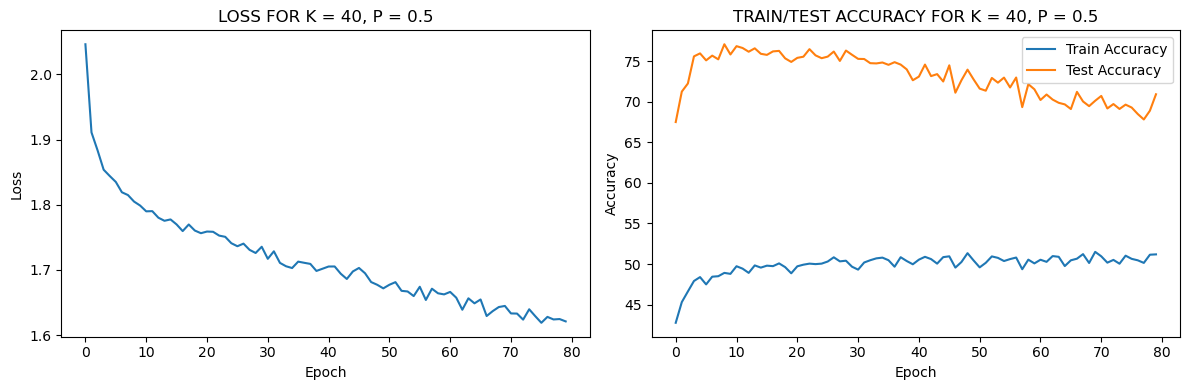


Mean Loss for k=40, p=0.5: 1.621
Max Train Accuracy for k=40, p=0.5: 51.19%
Max Test Accuracy for k=40, p=0.5: 70.92%

!!!!!!!!!!!!!!!!!!!!!! RUNNING FOR K=40, P=1.0 !!!!!!!!!!!!!!!!!!!!!!
/////////////////////////////////////////////////////////////////////
Epoch [10/80], Loss: 1.575, Train Accuracy: 56.86, Test Accuracy: 89.01
Epoch [20/80], Loss: 1.467, Train Accuracy: 58.28, Test Accuracy: 86.74
Epoch [30/80], Loss: 1.377, Train Accuracy: 59.99, Test Accuracy: 84.37
Epoch [40/80], Loss: 1.304, Train Accuracy: 61.40, Test Accuracy: 80.51
Epoch [50/80], Loss: 1.248, Train Accuracy: 63.30, Test Accuracy: 77.73
Epoch [60/80], Loss: 1.189, Train Accuracy: 64.15, Test Accuracy: 75.92
Epoch [70/80], Loss: 1.148, Train Accuracy: 65.77, Test Accuracy: 74.35
Epoch [80/80], Loss: 1.104, Train Accuracy: 66.69, Test Accuracy: 72.17

---------------------- FOR K: 40, P: 1.0 THE PLOTS ARE AS FOLLOWS ----------------------



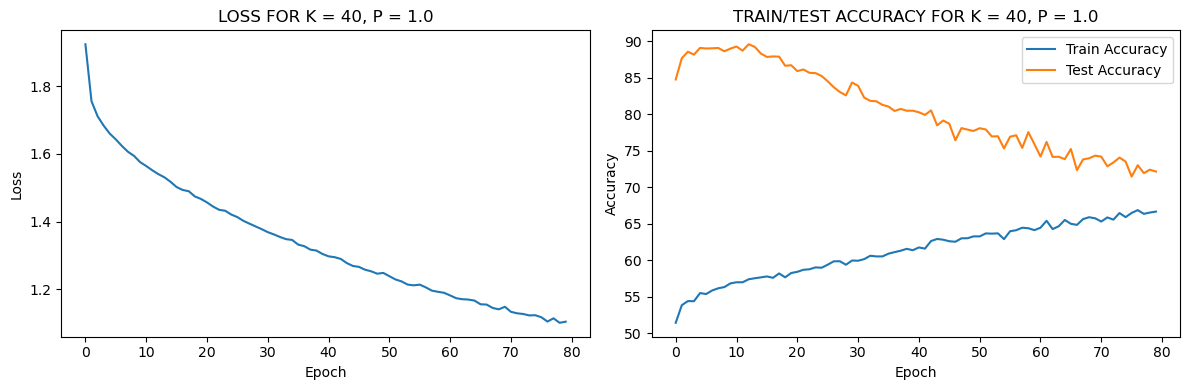


Mean Loss for k=40, p=1.0: 1.104
Max Train Accuracy for k=40, p=1.0: 66.69%
Max Test Accuracy for k=40, p=1.0: 72.17%

Wall time: 1h 12min 11s


In [18]:
%%time

for k in k_for_noisy:
  for p in p_for_noisy:
    t3_loss, t3_train_acc, t3_test_acc = general_shallow_net(noisy_train_loader, test_loader, 'ADAM', k, p, num_epochs)
    
    t31_mean_loss = t3_loss[-1]
    t31_max_train_acc = t3_train_acc[-1]
    t31_max_test_acc = t3_test_acc[-1]

    print(f'Mean Loss for k={k}, p={p}: {t31_mean_loss:.3f}')
    print(f'Max Train Accuracy for k={k}, p={p}: {t31_max_train_acc:.2f}%')
    print(f'Max Test Accuracy for k={k}, p={p}: {t31_max_test_acc:.2f}%')
    
    t3_total_summary = {'Hidden Units': k, 'Dropout Factor': p, 'Mean Loss': t31_mean_loss, 'Train Accuracy': t31_max_train_acc, 'Test Accuracy': t31_max_test_acc}
    task3_results.append(t3_total_summary)

    print()

### *Fix p = 1.0 which is the case of “no dropout regularization”. Plot the test and training accuracy as a function of k. As k increases, does the performance improve? At what k, training accuracy becomes 100% ?*

In [19]:
task3_results_df = pd.DataFrame(task3_results)
task3_results_df

,Hidden Units,Dropout Factor,Mean Loss,Train Accuracy,Test Accuracy
0,1,0.1,2.302488,10.38,9.789495
1,1,0.5,2.253589,12.60,13.652156
2,1,1.0,2.302473,10.38,9.789495
3,5,0.1,2.302505,10.38,9.789495
4,5,0.5,2.164142,20.33,27.089720
5,5,1.0,1.704800,52.57,76.844472
6,10,0.1,2.302290,10.38,9.789495
7,10,0.5,1.931062,34.80,49.407317
8,10,1.0,1.530597,55.80,77.896996
9,20,0.1,2.265271,12.60,14.285714


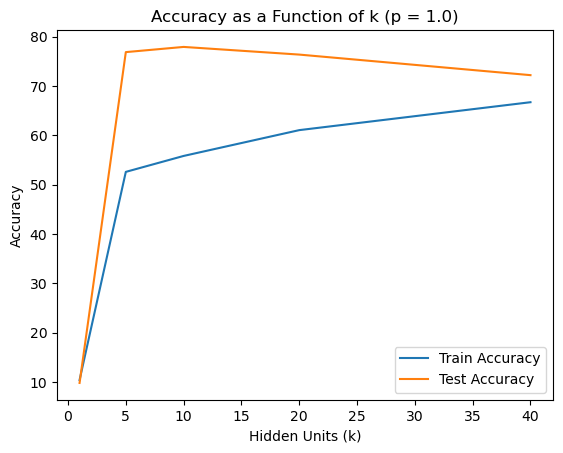

In [20]:
# Filter the DataFrame for rows where p = 1.0
filtered_df = task3_results_df[task3_results_df['Dropout Factor'] == 1.0]

# Plot the test and training accuracy
plt.plot(filtered_df['Hidden Units'], filtered_df['Train Accuracy'], label='Train Accuracy')
plt.plot(filtered_df['Hidden Units'], filtered_df['Test Accuracy'], label='Test Accuracy')
plt.title('Accuracy as a Function of k (p = 1.0)')
plt.xlabel('Hidden Units (k)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As, K increases, the performance of the model does not seems to improve. Rather, it looks like the model is going to face overfitting.
Since, noise is introduced in the train Data, it is getting more difficult for the model to fit on the training data than the test Data.
Thereby showing Test Accuracy greater than the Training Accuracy.

For no value of K, the model acheives 100% training Accuracy

### Plot the training and test accuracy as a function of k and for different p ∈ P on the  same plot. What is the role of p on training accuracy? When p is smaller, is it easier to optimize or more difficult? For each choice of p, determine at what choice of k, training accuracy becomes 100%.

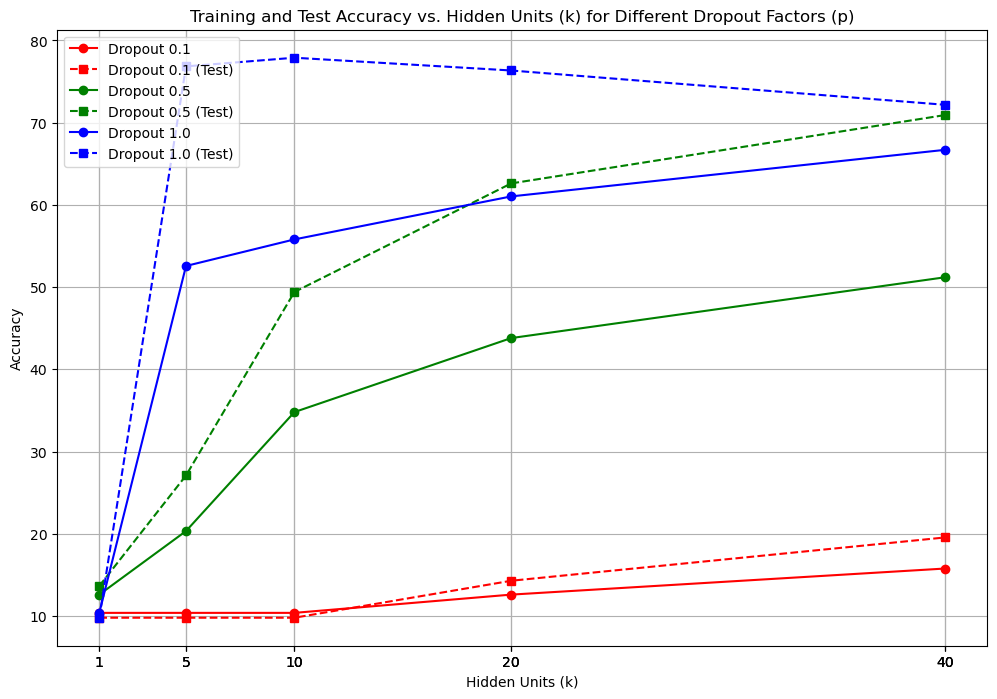

In [26]:
# Group the DataFrame by Dropout Factor
grouped_df = task3_results_df.groupby('Dropout Factor')

# Set the colors for the plot
colors = ['r', 'g', 'b']

# Plot the training and test accuracy for different Dropout Factors
plt.figure(figsize=(12, 8))

for i, (dropout, group) in enumerate(grouped_df):
    plt.plot(group['Hidden Units'], group['Train Accuracy'], marker='o', color=colors[i], label=f'Dropout {dropout}')
    plt.plot(group['Hidden Units'], group['Test Accuracy'], marker='s', color=colors[i], linestyle='--', label=f'Dropout {dropout} (Test)')

plt.title('Training and Test Accuracy vs. Hidden Units (k) for Different Dropout Factors (p)')
plt.xlabel('Hidden Units (k)')
plt.ylabel('Accuracy')
plt.xticks(task2_results_df['Hidden Units'])
plt.legend()
plt.grid(True)
plt.show()

As P (Dropout Factor) increases, the Training Accuracy of the Model for a given and fixed depth also improves. When P is smaller, it is difficult to Optimize. 

For no values of K and P we get Training Accuracy of 100%

## *TASK 4 - (3 PTS)*

Comment on the differences between Step 2 and Step 3. How does noise change things? For which setup dropout is more useful?

As the Width increases, the model becomes more complex and generalizes better on the unseen data thereby giving higher accuracy in step 2. But in step 3 with the addition of noise, we observe lower training accuracy.

As the dropout factor increases increases the accuracy lowers in the step 2. But in Step 3 the test accuracy is lower than the train accuracy, thereby establishing the overfitting of the model.

Hence, dropout is more useful for setup 2.